In [1]:
from ipaddress import summarize_address_range
from scipy.io import mmread
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# unspliced
m_u = mmread('/Users/wanglab/Documents/ShengyuLi/Velocity/data/jmlab_velocyto/atlas_data/weiqing_sparse2normal/unspliced_trans.mtx')
M_u=pd.DataFrame.sparse.from_spmatrix(m_u)

# spliced
m_s = mmread('/Users/wanglab/Documents/ShengyuLi/Velocity/data/jmlab_velocyto/atlas_data/weiqing_sparse2normal/spliced_trans.mtx')
M_s=pd.DataFrame.sparse.from_spmatrix(m_s)

# metadata
meta=pd.read_table('/Users/wanglab/Documents/ShengyuLi/Velocity/data/jmlab_velocyto/atlas_data/meta.tab') # 139331 rows × 18 columns
genes=pd.read_table('/Users/wanglab/Documents/ShengyuLi/Velocity/data/jmlab_velocyto/atlas_data/genes.tsv',header=None) 


In [2]:
# Mouse gastrulation
import scanpy
adata_paper =scanpy.read ('/Users/wanglab/Documents/ShengyuLi/Velocity/data/Gastrulation/erythroid_lineage.h5ad')

In [10]:
paper_stage=set(adata_paper.obs.stage)
paper_celltype=set(adata_paper.obs.celltype)
print(paper_stage)
print(paper_celltype)

{'E7.0', 'E7.25', 'E7.5', 'E8.25', 'E7.75', 'E8.5', 'E8.0'}
{'Erythroid2', 'Blood progenitors 2', 'Erythroid3', 'Erythroid1', 'Blood progenitors 1'}


In [20]:
meta_filtered=meta[(meta.stage.isin(paper_stage)) & (meta.celltype.isin(paper_celltype))]
meta_filtered
# select by cell - idx
idx_filter_cell=meta_filtered.index
M_s_cell_filtered=M_s[M_s.columns.intersection(idx_filter_cell)] # 29452 rows × 9815 columns
M_u_cell_filtered=M_u[M_u.columns.intersection(idx_filter_cell)] # 29452 rows × 9815 columns
M_s_cell_filtered

,362,381,384,392,397,409,446,463,483,494,...,139284,139286,139287,139298,139314,139317,139320,139325,139326,139329
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29447,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29448,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29449,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
29450,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [75]:
##################
# build raw_data #
##################
gene_num=len(M_s_cell_filtered)
cell_num=len(M_s_cell_filtered.columns)

genelist=genes[1]

# # gene_list
# gene_list_df = pd.DataFrame(np.repeat(genelist, cell_num))
# gene_list_df.columns=['gene_list']

# # u0 & s0
# M_s_fin_np=M_s_cell_filtered.to_numpy().reshape((gene_num*cell_num,1))
# M_u_fin_np=M_u_cell_filtered.to_numpy().reshape((gene_num*cell_num,1))
# M_s_fin=pd.DataFrame({'s0':list(M_s_fin_np)})
# M_u_fin=pd.DataFrame({'u0':list(M_u_fin_np)})

In [76]:
import scvelo as scv
from utilities import adata_to_raw
import anndata


In [77]:
adata_build_all_gene_in_blood=anndata.AnnData(
    X=M_s_cell_filtered.T,
    layers={
        'unspliced':M_u_cell_filtered.T.to_numpy(),
        'spliced':M_s_cell_filtered.T.to_numpy()
    }
)

In [78]:
adata_build_all_gene_in_blood.var.index=genelist
adata_build_all_gene_in_blood.obs.index=meta_filtered['barcode']

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


computing neighbors
    finished (0:00:09) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
Normalized count data: X, spliced, unspliced.
computing moments based on connectivities
    finished (0:00:11) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


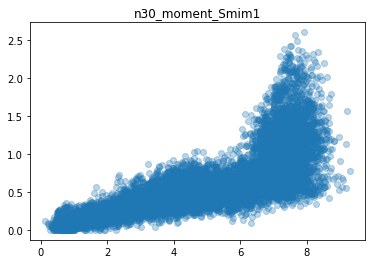

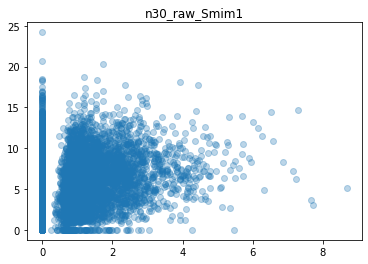

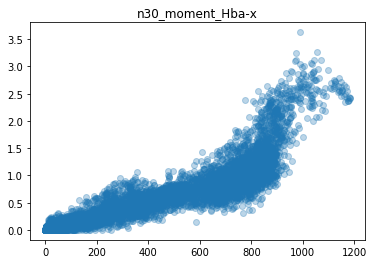

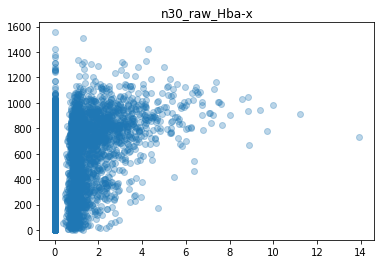

In [80]:
# plt
adata_build_all_gene_in_blood_copy=adata_build_all_gene_in_blood.copy()
adata_build_all_gene_in_blood_copy.obs_names_make_unique()
# adata_build_all_gene_in_blood_copy.var_names_make_unique()
# scv.pp.filter_and_normalize(adata_build_all_gene_in_blood_copy)
scv.pp.remove_duplicate_cells(adata_build_all_gene_in_blood_copy)
scv.pp.neighbors(adata_build_all_gene_in_blood_copy)
# for n in[10,30,50,100,200]:
for n in[30]:
    scv.pp.moments(adata_build_all_gene_in_blood_copy, n_neighbors=n)
    # for gene in adata_build_all_gene_in_blood_copy.var.index[0:30]:
    for gene in ['Smim1', 'Hba-x']:
    
        data2 = adata_build_all_gene_in_blood_copy[:,adata_build_all_gene_in_blood_copy.var.index.isin([gene])].copy()
        s0 = data2.layers['Ms']
        u0=data2.layers['Mu']
        plt.figure()
        plt.title('n'+str(n)+'_moment_'+gene)
        plt.scatter(s0,u0,alpha=0.3)

        u0 = data2.layers['spliced']
        s0=data2.layers['unspliced']
        plt.figure()
        plt.title('n'+str(n)+'_raw_'+gene)
        plt.scatter(s0,u0,alpha=0.3)

In [83]:
# gastrulation all data 

adata_paper =scanpy.read ('/Users/wanglab/Documents/ShengyuLi/Velocity/data/raw_data/gastrulation.h5ad')
adata_paper_bkup=adata_paper.copy()



In [84]:
adata_paper

AnnData object with n_obs × n_vars = 89267 × 53801
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

In [85]:
adata_paper.obs

,barcode,sample,stage,sequencing.batch,theiler,doub.density,doublet,cluster,cluster.sub,cluster.stage,...,haem_subclust,endo_gephiX,endo_gephiY,endo_trajectoryName,endo_trajectoryDPT,endo_gutX,endo_gutY,endo_gutDPT,endo_gutCluster,cell_velocyto_loom
index,,,,,,,,,,,,,,,,,,,,,
cell_1,AAAGGCCTCCACAA,1,E6.5,1,TS9,0.043114,False,2.0,4.0,2.0,...,nan,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,possorted_genome_bam_7SUA3:AAAGGCCTCCACAAx
cell_2,AACAAACTCGCCTT,1,E6.5,1,TS9,1.129713,False,12.0,1.0,1.0,...,nan,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,possorted_genome_bam_7SUA3:AACAAACTCGCCTTx
cell_6,AACATATGAATCGC,1,E6.5,1,TS9,1.254709,False,1.0,1.0,3.0,...,nan,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,possorted_genome_bam_7SUA3:AACATATGAATCGCx
cell_8,AACCGATGGCTTCC,1,E6.5,1,TS9,1.345759,False,2.0,1.0,2.0,...,nan,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,possorted_genome_bam_7SUA3:AACCGATGGCTTCCx
cell_9,AACGTGTGCTCTAT,1,E6.5,1,TS9,1.146369,False,2.0,1.0,2.0,...,nan,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,possorted_genome_bam_7SUA3:AACGTGTGCTCTATx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cell_139326,TTTCGAACGGTGAG,37,E8.5,3,TS12,0.476074,False,18.0,2.0,19.0,...,Ery4,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,possorted_genome_bam_DRLGW:TTTCGAACGGTGAGx
cell_139327,TTTCGAACTAACCG,37,E8.5,3,TS12,0.303505,False,18.0,2.0,19.0,...,Ery4,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,possorted_genome_bam_DRLGW:TTTCGAACTAACCGx
cell_139329,TTTCTACTGGGATG,37,E8.5,3,TS12,0.344835,False,13.0,2.0,18.0,...,nan,NaN,NaN,nan,NaN,NaN,NaN,NaN,nan,possorted_genome_bam_DRLGW:TTTCTACTGGGATGx


In [160]:
# our choice
stage_endo_blood=['E7.25', 'E7.5', 'E7.75', 'E8.0', 'E8.25']
celltype_endo_blood=['Haematoendothelial progenitors','Blood progenitors 1', 'Blood progenitors 2', 'Endothelium']

# in paper
stage_endo_blood={'E7.0', 'E7.25', 'E7.5', 'E8.25', 'E7.75', 'E8.5', 'E8.0'}
celltype_endo_blood={'Erythroid2', 'Blood progenitors 2', 'Erythroid3', 'Erythroid1', 'Blood progenitors 1'}

# mix
stage_endo_blood={'E7.0', 'E7.25', 'E7.5', 'E8.25', 'E7.75', 'E8.5', 'E8.0'}
celltype_endo_blood={'Erythroid2', 'Blood progenitors 2', 'Erythroid3', 'Erythroid1', 'Blood progenitors 1',
                    'Haematoendothelial progenitors','Blood progenitors 1', 'Endothelium'}

# del 'Endothelium'(green)
stage_endo_blood={'E7.0', 'E7.25', 'E7.5', 'E8.25', 'E7.75', 'E8.5', 'E8.0'}
celltype_endo_blood={'Erythroid2', 'Blood progenitors 2', 'Erythroid3', 'Erythroid1', 'Blood progenitors 1',
                    'Haematoendothelial progenitors','Blood progenitors 1'}

In [161]:
adata_paper_endo_blood

AnnData object with n_obs × n_vars = 13413 × 2000
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

Please `pip install adjustText` for auto-aligning texts


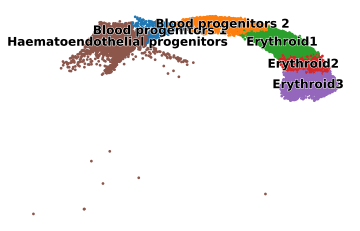

Filtered out 47193 genes that are detected 30 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:04) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:03) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
saving figure to file /Users/wanglab/Documents/ShengyuLi/Velocity/data/Gastrulation/scatter_s0u0/moment_n_100/scatter_s0u0_Sox17.pdf
saving figure to file /Users/wanglab/Documents/ShengyuLi/Velocity/data/Gastrulation/scatter_s0u0/moment_n_100/scatter_s0u0_Tram1.pdf


In [162]:
adata_paper_endo_blood=adata_paper[adata_paper.obs.stage.isin(stage_endo_blood) & adata_paper.obs.celltype.isin(celltype_endo_blood),:].copy()
scv.pl.scatter(adata_paper_endo_blood, c='celltype', s=30, legend_align_text=True, legend_fontsize=12, title='')
scv.pp.filter_and_normalize(adata_paper_endo_blood, min_shared_counts=30, n_top_genes=2000)

n_list=[100]
gene_list = adata_paper_endo_blood.var_names[0:2]
for n in n_list:
    scv.pp.moments(adata_paper_endo_blood,n_neighbors=n)
    for gene in gene_list:
        scv.pl.scatter(adata_paper_endo_blood, basis=var_names, c='celltype', vkey='velocity', frameon='artist', s=40, dpi=80,save='/Users/wanglab/Documents/ShengyuLi/Velocity/data/Gastrulation/scatter_s0u0/moment_n_100/scatter_s0u0_'+gene+'.pdf',show=False)


# for n in n_list:
#     scv.pp.moments(adata_paper_endo_blood,n_neighbors=n)
#     # scv.tl.velocity(adata_paper_endo_blood)
#     print(adata_paper_endo_blood.var_names)
#     # for gene in adata_paper_endo_blood.var_names[30:50]:
#     for gene in adata_paper_endo_blood.var_names[30:50]:
#         adata_onegene=adata_paper_endo_blood[:,adata_paper_endo_blood.var.index.isin([gene])].copy()

#         s0_onegene = adata_onegene.layers['Ms'].T[0]
#         u0_onegene = adata_onegene.layers['Mu'].T[0]

#         plt.figure()
#         plt.title('n'+str(n)+"_"+gene)
#         plt.scatter(s0_onegene,u0_onegene,alpha=0.3)

In [ ]:
# adata_paper_endo_blood adata to raw (using 20 to 25 # del 'Endothelium'(green))

In [164]:
adata_paper_endo_blood

AnnData object with n_obs × n_vars = 12329 × 2000
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'celltype_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced', 'Ms', 'Mu'
    obsp: 'distances', 'connectivities'

In [234]:
# from utilities import adata_to_raw_with_embed
def adata_to_raw_with_embed(adata,save_path,gene_list=None):
    '''convert adata to raw data format with embedding info
    data:
    save_path:
    gene_list (optional):

    return: panda dataframe with gene_list,u0,s0,cellID,clusters,embedding1,embedding2
    
    run: test=adata_to_raw(adata,'/Users/shengyuli/Library/CloudStorage/OneDrive-HoustonMethodist/work/Velocity/bin/cellDancer-development_20220128/src/output/test.csv',gene_list=genelist_all)
    ref: mel - loom_to_celldancer_raw.py
    '''
    def adata_to_raw_one_gene(data, para, gene):
        '''
        convert adata to raw data format (one gene)
        data: an anndata
        para: the varable name of u0, s0, and gene name
        para = ['Mu', 'Ms']
        '''
        data2 = data[:, data.var.index.isin([gene])].copy()
        u0 = data2.layers[para[0]][:,0].copy().astype(np.float32)
        s0 = data2.layers[para[1]][:,0].copy().astype(np.float32)
        raw_data = pd.DataFrame({'gene_list':gene, 'u0':u0, 's0':s0})
        return(raw_data)

    if gene_list is None: gene_list=adata.var.index

    for i,gene in enumerate(gene_list):
        print("processing:"+str(i)+"/"+str(len(adata.var_names)))
        data_onegene = adata_to_raw_one_gene(adata, para=['Mu', 'Ms'], gene=gene)
        if i==0:
            data_onegene.to_csv(save_path,header=True,index=False)
        else:
            data_onegene.to_csv(save_path,mode='a',header=False,index=False)
    
    # cell info
    gene_num=len(gene_list)
    cellID=pd.DataFrame({'cellID':adata.obs.index})
    celltype_meta=adata.obs['celltype'].reset_index(drop=True)
    celltype=pd.DataFrame({'clusters':celltype_meta})#
    embed_map=pd.DataFrame({'embedding1':adata.obsm['X_umap'][:,0],'embedding2':adata.obsm['X_umap'][:,1]})
    # embed_info_df = pd.concat([embed_info]*gene_num)
    embed_info=pd.concat([cellID,celltype,embed_map],axis=1)
    embed_raw=pd.concat([embed_info]*gene_num)
    embed_raw=embed_raw.reset_index(drop=True)
    
    raw_data=pd.read_csv(save_path)
    raw_data=pd.concat([raw_data,embed_raw],axis=1)
    
    raw_data.to_csv(save_path,header=True,index=False)

    return(raw_data)

In [238]:
gene_list=['Sox17', '2410006H16Rik', 'Smim1', 'Hba-x', 'Abi3', 'Akap12', 'Car4', 'Degs1','Dhrs11','Fn1','Grb10','H2afv','Hba-a1','Hba-x','Hspd1','Hspe1','Igf1','Igf2bp1','Klf7','Sgk3','Slc4a1','Tagln2','Timp3','Tns3','Tpd52l1','Ube2d1','Ugp2']
raw=adata_to_raw_with_embed(adata_paper_endo_blood,save_path='/Users/wanglab/Documents/ShengyuLi/Velocity/data/raw_data/mouse_endo_blood20to25.csv',gene_list=gene_list)

raw

processing:0/2000
processing:1/2000
processing:2/2000
processing:3/2000
processing:4/2000
processing:5/2000
processing:6/2000
processing:7/2000
processing:8/2000
processing:9/2000
processing:10/2000
processing:11/2000
processing:12/2000
processing:13/2000
processing:14/2000
processing:15/2000
processing:16/2000
processing:17/2000
processing:18/2000
processing:19/2000
processing:20/2000
processing:21/2000
processing:22/2000
processing:23/2000
processing:24/2000
processing:25/2000
processing:26/2000


,gene_list,u0,s0,cellID,clusters,embedding1,embedding2
0,Sox17,0.000000,0.043971,cell_363,Blood progenitors 2,3.460521,15.574629
1,Sox17,0.000000,0.000000,cell_382,Blood progenitors 2,2.490433,14.971734
2,Sox17,0.000000,0.018161,cell_385,Blood progenitors 2,2.351203,15.267069
3,Sox17,0.000000,0.000000,cell_393,Blood progenitors 2,5.899098,14.388825
4,Sox17,0.000000,0.000000,cell_398,Blood progenitors 2,4.823139,15.374831
...,...,...,...,...,...,...,...
332878,Ugp2,0.025012,0.333137,cell_139318,Erythroid3,8.032358,7.603037
332879,Ugp2,0.018323,0.430984,cell_139321,Erythroid3,10.352904,6.446736
332880,Ugp2,0.005458,0.363071,cell_139326,Erythroid3,9.464873,7.261099
332881,Ugp2,0.044752,0.533512,cell_139327,Erythroid3,9.990495,7.243880
